# C-SPAN Tracker
Tracking the campaign stops for `Beto O'Rourke` and `Julian Castro` using C-SPAN videos

<hr>

# What I'm doing :
I will be tracking C-SPAN's coverage of all announced democratic candidates to note any distinct differences. How do the smaller players fair in terms of coverage? What is the average video per candidate? Views per video? What are the buzzwords in the announcement speech vs the most recent speech?

## Importing modules

In [41]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
from selenium import webdriver
import datetime as dt  
import numpy as np
from dotenv import load_dotenv
load_dotenv()
import os
import json

api_key = os.getenv("GMAP_API")
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')

## Booting up BeautifulSoup
Grabbing candidate information from the Road to the White House Candidates page

In [42]:
response = requests.get("https://www.c-span.org/series/?roadToTheWhiteHouse#candidates-tab")
doc = BeautifulSoup(response.text)

In [43]:
## Zoning in on the running Democratic candidates
dems = doc.find("ul", class_="candidate-list").find_all("li", class_="D")
len(dems)

23

In [44]:
# All the info from the all-candidate page

rows = []

for dem in dems:
    row = {}
    row['Name'] = dem.find(class_="candidate D").text.strip()
    row['AnnounceDate'] = dem.find(class_="datetime").text.strip()
    row['Bio'] = dem.find(class_="candidate D")["href"]
    try:
        row['Slug'] = dem.find(class_="candidate-links").find_all("a")[1]['href']
    except: pass
    
    rows.append(row)

# rows

In [47]:
df = pd.DataFrame(rows, columns=["Name", "Slug", "AnnounceDate", "Bio"])

In [48]:
df.Bio = df.Bio.astype(str)
df.Bio

0          //www.c-span.org/person/?michaelbennet
1            //www.c-span.org/person/?josephbiden
2             //www.c-span.org/person/?corybooker
3         //www.c-span.org/person/?stevebullock02
4          //www.c-span.org/person/?petebuttigieg
5           //www.c-span.org/person/?juliancastro
6          //www.c-span.org/person/?johndelaney02
7           //www.c-span.org/person/?tulsigabbard
8      //www.c-span.org/person/?kirstengillibrand
9           //www.c-span.org/person/?kamalaharris
10     //www.c-span.org/person/?johnwhickenlooper
11             //www.c-span.org/person/?jayinslee
12          //www.c-span.org/person/?amyklobuchar
13           //www.c-span.org/person/?sethmoulton
14           //www.c-span.org/person/?betoorourke
15             //www.c-span.org/person/?timryan03
16         //www.c-span.org/person/?berniesanders
17          //www.c-span.org/person/?josephsestak
18          //www.c-span.org/person/?ericswalwell
19       //www.c-span.org/person/?elizabethwarren


## Cleaning it up a bit

In [49]:
df["AnnounceDate"] = df["AnnounceDate"].str.extract(":\s(.*)")
df['Slug'] = df['Slug'].str.extract("(personid.*)")
df['Bio'] = df['Bio'].str.extract("\?(.*)")

In [50]:
df.Bio.astype(str)

0          michaelbennet
1            josephbiden
2             corybooker
3         stevebullock02
4          petebuttigieg
5           juliancastro
6          johndelaney02
7           tulsigabbard
8      kirstengillibrand
9           kamalaharris
10     johnwhickenlooper
11             jayinslee
12          amyklobuchar
13           sethmoulton
14           betoorourke
15             timryan03
16         berniesanders
17          josephsestak
18          ericswalwell
19       elizabethwarren
20    mariannewilliamson
21            andrewyang
22          billdeblasio
Name: Bio, dtype: object

In [51]:
df.iloc[17,1] = "personid[]=1020918"

## Getting the date's formatted correctly

In [52]:
df['AnnounceDate'] = pd.to_datetime(df['AnnounceDate'], format="%B %d, %Y", errors='coerce')
df['AnnounceDate'] = df['AnnounceDate'].dt.strftime("%m/%d/%Y")

## Scraping the bio pages

In [53]:
def scrape_bio(row):
    regexp = re.compile(r'http://bioguide.*')
    url = "https://www.c-span.org/person/?" + row["Bio"]
    
    response = requests.get(url)
    doc = BeautifulSoup(response.text)
    for li in doc.find_all("li"):
        li.decompose()
    doc.find('footer').decompose()
    profile = doc.find(id="content")
    
    ## Print out the slug column
    print("Scraping", url)
    
    bio = {}

    bio['Name'] = profile.find('h1').text.strip()
    bio['IMG'] = profile.find('img')['src']
    bio['Official Bio'] = profile.find(href=regexp)
    
    bio['Description'] = []
    for desc in profile.find_all(itemprop="description"):
        bio['Description'].append(desc.text.strip())
    
    bio['Titles'] = []
    for titles in doc.find_all('span', class_=['title']):
        bio['Titles'].append(titles.text.strip())
    
    return pd.Series(bio)

In [54]:
bio_df = df.apply(scrape_bio, axis=1)

Scraping https://www.c-span.org/person/?michaelbennet
Scraping https://www.c-span.org/person/?michaelbennet
Scraping https://www.c-span.org/person/?josephbiden
Scraping https://www.c-span.org/person/?corybooker
Scraping https://www.c-span.org/person/?stevebullock02
Scraping https://www.c-span.org/person/?petebuttigieg
Scraping https://www.c-span.org/person/?juliancastro
Scraping https://www.c-span.org/person/?johndelaney02
Scraping https://www.c-span.org/person/?tulsigabbard
Scraping https://www.c-span.org/person/?kirstengillibrand
Scraping https://www.c-span.org/person/?kamalaharris
Scraping https://www.c-span.org/person/?johnwhickenlooper
Scraping https://www.c-span.org/person/?jayinslee
Scraping https://www.c-span.org/person/?amyklobuchar
Scraping https://www.c-span.org/person/?sethmoulton
Scraping https://www.c-span.org/person/?betoorourke
Scraping https://www.c-span.org/person/?timryan03
Scraping https://www.c-span.org/person/?berniesanders
Scraping https://www.c-span.org/person/?

In [55]:
bio_df.to_csv("candidate_info.csv", index=False)

In [56]:
bio_df

,Name,IMG,Official Bio,Description,Titles
0,Michael Bennet,https://images.c-span.org/Files/6de/2019062300...,"<a href=""http://bioguide.congress.gov/scripts/...",[Michael Farrand Bennet is an American busines...,"[U.S. Senator, D-CO View Map]"
1,Joe Biden Jr.,https://images.c-span.org/Files/993/2019062423...,"<a href=""http://bioguide.congress.gov/scripts/...",[Joseph Robinette Biden Jr. is an American pol...,"[U.S. Vice President, United StatesD, U.S. Sen..."
2,Cory Booker,https://images.c-span.org/Files/dbe/2019062423...,"<a href=""http://bioguide.congress.gov/scripts/...",[Cory Anthony Booker is an American politician...,"[U.S. Senator, D-NJ View Map, Mayor, Newark, N..."
3,Steve Bullock,https://images.c-span.org/Files/ff2/2019051721...,None,[On the C-SPAN Networks:Steve Bullock is a Gov...,"[Governor, MontanaD-Montana, Chair, Democratic..."
4,Pete Buttigieg,https://images.c-span.org/Files/e28/2019062221...,None,[On the C-SPAN Networks:Pete Buttigieg is a Ma...,"[Mayor, South Bend, IND]"
5,Julian Castro,https://images.c-span.org/Files/fc6/2019062222...,None,[On the C-SPAN Networks:Julian Castro was a Se...,"[Secretary, Department of Housing and Urban De..."
6,John K. Delaney,https://images.c-span.org/Files/26c/2019062222...,"<a href=""http://bioguide.congress.gov/scripts/...",[John Kevin Delaney is an American politician ...,"[U.S. Representative, D-MD 6th View Map, U.S. ..."
7,Tulsi Gabbard,https://images.c-span.org/Files/793/2019062913...,"<a href=""http://bioguide.congress.gov/scripts/...",[Tulsi Gabbard is an American politician servi...,"[U.S. Representative, D-HI 2nd View Map, Veter..."
8,Kirsten E. Gillibrand,https://images.c-span.org/Files/991/2019062220...,"<a href=""http://bioguide.congress.gov/scripts/...",[Kirsten Elizabeth Gillibrand is an American a...,"[U.S. Senator, D-NY View Map, U.S. Representat..."
9,Kamala D. Harris,https://images.c-span.org/Files/761/2018102322...,"<a href=""http://bioguide.congress.gov/scripts/...",[Kamala Devi Harris is an American attorney an...,"[U.S. Senator, D-CA View Map, District Attorne..."


## Joining the DataFrames

In [57]:
df = df.merge(bio_df, left_on='Name', right_on='Name')
df

,Name,Slug,AnnounceDate,Bio,IMG,Official Bio,Description,Titles
0,Michael Bennet,personid[]=1031622,05/02/2019,michaelbennet,https://images.c-span.org/Files/6de/2019062300...,"<a href=""http://bioguide.congress.gov/scripts/...",[Michael Farrand Bennet is an American busines...,"[U.S. Senator, D-CO View Map]"
1,Joe Biden Jr.,personid[]=34,04/25/2019,josephbiden,https://images.c-span.org/Files/993/2019062423...,"<a href=""http://bioguide.congress.gov/scripts/...",[Joseph Robinette Biden Jr. is an American pol...,"[U.S. Vice President, United StatesD, U.S. Sen..."
2,Cory Booker,personid[]=84679,02/01/2019,corybooker,https://images.c-span.org/Files/dbe/2019062423...,"<a href=""http://bioguide.congress.gov/scripts/...",[Cory Anthony Booker is an American politician...,"[U.S. Senator, D-NJ View Map, Mayor, Newark, N..."
3,Steve Bullock,personid[]=9276486,05/14/2019,stevebullock02,https://images.c-span.org/Files/ff2/2019051721...,None,[On the C-SPAN Networks:Steve Bullock is a Gov...,"[Governor, MontanaD-Montana, Chair, Democratic..."
4,Pete Buttigieg,personid[]=106618,04/14/2019,petebuttigieg,https://images.c-span.org/Files/e28/2019062221...,None,[On the C-SPAN Networks:Pete Buttigieg is a Ma...,"[Mayor, South Bend, IND]"
5,Julian Castro,personid[]=9278200,01/12/2019,juliancastro,https://images.c-span.org/Files/fc6/2019062222...,None,[On the C-SPAN Networks:Julian Castro was a Se...,"[Secretary, Department of Housing and Urban De..."
6,John K. Delaney,personid[]=67856,08/10/2017,johndelaney02,https://images.c-span.org/Files/26c/2019062222...,"<a href=""http://bioguide.congress.gov/scripts/...",[John Kevin Delaney is an American politician ...,"[U.S. Representative, D-MD 6th View Map, U.S. ..."
7,Tulsi Gabbard,personid[]=1025291,01/11/2019,tulsigabbard,https://images.c-span.org/Files/793/2019062913...,"<a href=""http://bioguide.congress.gov/scripts/...",[Tulsi Gabbard is an American politician servi...,"[U.S. Representative, D-HI 2nd View Map, Veter..."
8,Kirsten E. Gillibrand,personid[]=1022862,01/14/2019,kirstengillibrand,https://images.c-span.org/Files/991/2019062220...,"<a href=""http://bioguide.congress.gov/scripts/...",[Kirsten Elizabeth Gillibrand is an American a...,"[U.S. Senator, D-NY View Map, U.S. Representat..."
9,Kamala D. Harris,personid[]=1018696,01/21/2019,kamalaharris,https://images.c-span.org/Files/761/2018102322...,"<a href=""http://bioguide.congress.gov/scripts/...",[Kamala Devi Harris is an American attorney an...,"[U.S. Senator, D-CA View Map, District Attorne..."


## Export the dataframe to a `.csv`

In [58]:
df.to_csv("candidates-cspan.csv", index=False)

In [59]:
df.head()

,Name,Slug,AnnounceDate,Bio,IMG,Official Bio,Description,Titles
0,Michael Bennet,personid[]=1031622,05/02/2019,michaelbennet,https://images.c-span.org/Files/6de/2019062300...,"<a href=""http://bioguide.congress.gov/scripts/...",[Michael Farrand Bennet is an American busines...,"[U.S. Senator, D-CO View Map]"
1,Joe Biden Jr.,personid[]=34,04/25/2019,josephbiden,https://images.c-span.org/Files/993/2019062423...,"<a href=""http://bioguide.congress.gov/scripts/...",[Joseph Robinette Biden Jr. is an American pol...,"[U.S. Vice President, United StatesD, U.S. Sen..."
2,Cory Booker,personid[]=84679,02/01/2019,corybooker,https://images.c-span.org/Files/dbe/2019062423...,"<a href=""http://bioguide.congress.gov/scripts/...",[Cory Anthony Booker is an American politician...,"[U.S. Senator, D-NJ View Map, Mayor, Newark, N..."
3,Steve Bullock,personid[]=9276486,05/14/2019,stevebullock02,https://images.c-span.org/Files/ff2/2019051721...,None,[On the C-SPAN Networks:Steve Bullock is a Gov...,"[Governor, MontanaD-Montana, Chair, Democratic..."
4,Pete Buttigieg,personid[]=106618,04/14/2019,petebuttigieg,https://images.c-span.org/Files/e28/2019062221...,None,[On the C-SPAN Networks:Pete Buttigieg is a Ma...,"[Mayor, South Bend, IND]"


## Reading it back in

# Exporting
Because it takes a while

In [49]:
links.shape

(344, 19)

In [21]:
links.to_csv("cspan-candidates-unedited.csv", index=False)

In [22]:
df = pd.read_csv("cspan-candidates-unedited.csv")

# Cleaning it up

In [23]:
## Changing views to a raw number
df.Views = df.Views.str.extract("\s*(.*)\sViews")

In [24]:
df.Date = pd.to_datetime(df.Date, format="%B  %d, %Y", errors='coerce').dt.strftime("%m/%d/%Y")

In [25]:
df.Date = pd.to_datetime(df.Date, format="%B  %d, %Y", errors='coerce')
df.Views = df.Views.str.extract(r"(.*) Views")

In [56]:
df

,Announce Date,Category,Date,Description,Format,Headline,Host Organization,IMG,In_Video,Link,Location,Name,Official Bio,Prog.Hidden.ID,Program ID,Slug,Titles,Transcription,Views
0,05/02/2019,Public Affairs Event,NaT,"Senator Michael Bennet (D-CO), a 2020 Democrat...",Speech,South Carolina Democratic Party Convention: Se...,Democratic Party of South Carolina,https://images.c-span.org/Files/6de/2019062300...,['Michael Bennet'],https://www.c-span.org/video/?461983-16/south-...,"Columbia, South Carolina, United States",Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",528856.0,461983-16,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""THANK YOU EVERYBODY. THANK YOU CHAIRMAN MALL...",NaN
1,05/02/2019,Public Affairs Event,NaT,Planned Parenthood Action Fund hosted a presid...,Forum,"Planned Parenthood Candidates Forum, Part 3",Planned Parenthood Action Fund,https://images.c-span.org/Files/6de/2019062300...,"['Johanny Adames', 'Stephen ""Steve"" K. Benjami...",https://www.c-span.org/video/?461882-5/planned...,"Columbia, South Carolina, United States",Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",528777.0,461882-5,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""BEING HERE. >> A LOT OF LOVE FOR YOU TODAY, ...",NaN
2,05/02/2019,Public Affairs Event,NaT,Rep. Jim Clyburn (D-SC) held his “world famous...,Forum,Representative Jim Clyburn Fish Fry,"U.S. House of Representatives | Clyburn, J. (D...",https://images.c-span.org/Files/6de/2019062300...,"['Michael Bennet', 'Cory Booker', 'Pete Buttig...",https://www.c-span.org/video/?461893-1/democra...,"Columbia, South Carolina, United States",Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",528531.0,461893-1,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""WILL ALLOW HIM A GENEROUS ONE MINUTE FOR REM...",NaN
3,05/02/2019,Public Affairs Event,NaT,Nine 2020 Democratic presidential candidates s...,Forum,"Poor People's Campaign Presidential Forum, Sen...",Poor People's Campaign,https://images.c-span.org/Files/6de/2019062300...,"['William J. Barber II', 'Michael Bennet', 'Jo...",https://www.c-span.org/video/?461798-4/poor-pe...,"Washington, District of Columbia, United States",Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",528468.0,461798-4,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""WE'RE ABOUT TO BEGIN NOW. >> I WANT TO THANK...",NaN
4,05/02/2019,Public Affairs Event,NaT,The Iowa Democratic Party held its Hall of Fam...,Speech,Iowa Democratic Party Hall of Fame Forum,Democratic Party of Iowa,https://images.c-span.org/Files/6de/2019062300...,"['Travis Anderson', 'Cindy Axne', 'Michael Ben...",https://www.c-span.org/video/?461356-1/white-h...,"Cedar Rapids, Iowa, United States",Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",527574.0,461356-1,personid[]=1031622,"['U.S. Senator, D-CO View Map']",['I HAVE A LOT OF\nCHALLENGES WITH FALLING ASL...,NaN
5,05/02/2019,Public Affairs Event,NaT,"Senator Michael Bennet (D-CO), in an appearanc...",Broadcast,Senator Michael Bennet on Russian Interference...,"CBS | ""Face the Nation""",https://images.c-span.org/Files/6de/2019062300...,['Michael Bennet'],https://www.c-span.org/video/?460675-3/senator...,No Location,Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",526458.0,460675-3,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""ROBERT MUELLER HAD AN ISSUE WITH CONTEXT I D...",NaN
6,05/02/2019,Public Affairs Event,NaT,"Senator Michael Bennet (D-CO), a 2020 Democrat...",Speech,"Senator Michael Bennet in Bedford, New Hampshire",Bennet Presidential Campaign,https://images.c-span.org/Files/6de/2019062300...,"['David Van Der Beken', 'Michael Bennet']",https://www.c-span.org/video/?460642-1/senator...,"Bedford, New Hampshire, United States",Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",526401.0,460642-1,personid[]=1031622,"['U.S. Senator, D-CO View Map']","['VOICES FROM THE ROAD\nON C-SPA

In [50]:
df.shape

(344, 19)

In [27]:
geometry_df = []
for place in df['Location']:
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json'
        keys = {'address': place, 'key': api_key}
        r = requests.get(url,params=keys)
        result_dic = r.json()
        lat = result_dic['results'][0]['geometry']['location']['lat']
        long = result_dic['results'][0]['geometry']['location']['lng']
        coords = []
        coords.append(float(long))
        coords.append(float(lat))
        mygeometry = {'place': place, 'geometry.type': 'Point','geometry.coordinates': coords}
        geometry_df.append(mygeometry)
    except: pass
geometry_df

[{'place': 'Columbia, South Carolina, United States',
  'geometry.type': 'Point',
  'geometry.coordinates': [-81.0348144, 34.0007104]},
 {'place': 'Columbia, South Carolina, United States',
  'geometry.type': 'Point',
  'geometry.coordinates': [-81.0348144, 34.0007104]},
 {'place': 'Columbia, South Carolina, United States',
  'geometry.type': 'Point',
  'geometry.coordinates': [-81.0348144, 34.0007104]},
 {'place': 'Washington, District of Columbia, United States',
  'geometry.type': 'Point',
  'geometry.coordinates': [-77.0368707, 38.9071923]},
 {'place': 'Cedar Rapids, Iowa, United States',
  'geometry.type': 'Point',
  'geometry.coordinates': [-91.6656232, 41.9778795]},
 {'place': 'Bedford, New Hampshire, United States',
  'geometry.type': 'Point',
  'geometry.coordinates': [-71.51320079999999, 42.9463291]},
 {'place': 'Chicago, Illinois, United States',
  'geometry.type': 'Point',
  'geometry.coordinates': [-87.6297982, 41.8781136]},
 {'place': 'Columbia, South Carolina, United Sta

In [28]:
geometry_df = pd.DataFrame(geometry_df)

In [51]:
geometry_df.shape

(341, 3)

In [57]:
df

,Announce Date,Category,Date,Description,Format,Headline,Host Organization,IMG,In_Video,Link,Location,Name,Official Bio,Prog.Hidden.ID,Program ID,Slug,Titles,Transcription,Views
0,05/02/2019,Public Affairs Event,NaT,"Senator Michael Bennet (D-CO), a 2020 Democrat...",Speech,South Carolina Democratic Party Convention: Se...,Democratic Party of South Carolina,https://images.c-span.org/Files/6de/2019062300...,['Michael Bennet'],https://www.c-span.org/video/?461983-16/south-...,"Columbia, South Carolina, United States",Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",528856.0,461983-16,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""THANK YOU EVERYBODY. THANK YOU CHAIRMAN MALL...",NaN
1,05/02/2019,Public Affairs Event,NaT,Planned Parenthood Action Fund hosted a presid...,Forum,"Planned Parenthood Candidates Forum, Part 3",Planned Parenthood Action Fund,https://images.c-span.org/Files/6de/2019062300...,"['Johanny Adames', 'Stephen ""Steve"" K. Benjami...",https://www.c-span.org/video/?461882-5/planned...,"Columbia, South Carolina, United States",Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",528777.0,461882-5,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""BEING HERE. >> A LOT OF LOVE FOR YOU TODAY, ...",NaN
2,05/02/2019,Public Affairs Event,NaT,Rep. Jim Clyburn (D-SC) held his “world famous...,Forum,Representative Jim Clyburn Fish Fry,"U.S. House of Representatives | Clyburn, J. (D...",https://images.c-span.org/Files/6de/2019062300...,"['Michael Bennet', 'Cory Booker', 'Pete Buttig...",https://www.c-span.org/video/?461893-1/democra...,"Columbia, South Carolina, United States",Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",528531.0,461893-1,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""WILL ALLOW HIM A GENEROUS ONE MINUTE FOR REM...",NaN
3,05/02/2019,Public Affairs Event,NaT,Nine 2020 Democratic presidential candidates s...,Forum,"Poor People's Campaign Presidential Forum, Sen...",Poor People's Campaign,https://images.c-span.org/Files/6de/2019062300...,"['William J. Barber II', 'Michael Bennet', 'Jo...",https://www.c-span.org/video/?461798-4/poor-pe...,"Washington, District of Columbia, United States",Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",528468.0,461798-4,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""WE'RE ABOUT TO BEGIN NOW. >> I WANT TO THANK...",NaN
4,05/02/2019,Public Affairs Event,NaT,The Iowa Democratic Party held its Hall of Fam...,Speech,Iowa Democratic Party Hall of Fame Forum,Democratic Party of Iowa,https://images.c-span.org/Files/6de/2019062300...,"['Travis Anderson', 'Cindy Axne', 'Michael Ben...",https://www.c-span.org/video/?461356-1/white-h...,"Cedar Rapids, Iowa, United States",Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",527574.0,461356-1,personid[]=1031622,"['U.S. Senator, D-CO View Map']",['I HAVE A LOT OF\nCHALLENGES WITH FALLING ASL...,NaN
5,05/02/2019,Public Affairs Event,NaT,"Senator Michael Bennet (D-CO), in an appearanc...",Broadcast,Senator Michael Bennet on Russian Interference...,"CBS | ""Face the Nation""",https://images.c-span.org/Files/6de/2019062300...,['Michael Bennet'],https://www.c-span.org/video/?460675-3/senator...,No Location,Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",526458.0,460675-3,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""ROBERT MUELLER HAD AN ISSUE WITH CONTEXT I D...",NaN
6,05/02/2019,Public Affairs Event,NaT,"Senator Michael Bennet (D-CO), a 2020 Democrat...",Speech,"Senator Michael Bennet in Bedford, New Hampshire",Bennet Presidential Campaign,https://images.c-span.org/Files/6de/2019062300...,"['David Van Der Beken', 'Michael Bennet']",https://www.c-span.org/video/?460642-1/senator...,"Bedford, New Hampshire, United States",Michael Bennet,"<a href=""http://bioguide.congress.gov/scripts/...",526401.0,460642-1,personid[]=1031622,"['U.S. Senator, D-CO View Map']","['VOICES FROM THE ROAD\nON C-SPA

In [64]:
uh = df.merge(geometry_df, left_on='Location', right_on='place')

In [69]:
uh.head()

,Announce Date,Category,Date,Description,Format,Headline,Host Organization,IMG,In_Video,Link,...,Official Bio,Prog.Hidden.ID,Program ID,Slug,Titles,Transcription,Views,geometry.coordinates,geometry.type,place
0,05/02/2019,Public Affairs Event,NaT,"Senator Michael Bennet (D-CO), a 2020 Democrat...",Speech,South Carolina Democratic Party Convention: Se...,Democratic Party of South Carolina,https://images.c-span.org/Files/6de/2019062300...,['Michael Bennet'],https://www.c-span.org/video/?461983-16/south-...,...,"<a href=""http://bioguide.congress.gov/scripts/...",528856.0,461983-16,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""THANK YOU EVERYBODY. THANK YOU CHAIRMAN MALL...",NaN,"[-81.0348144, 34.0007104]",Point,"Columbia, South Carolina, United States"
1,05/02/2019,Public Affairs Event,NaT,"Senator Michael Bennet (D-CO), a 2020 Democrat...",Speech,South Carolina Democratic Party Convention: Se...,Democratic Party of South Carolina,https://images.c-span.org/Files/6de/2019062300...,['Michael Bennet'],https://www.c-span.org/video/?461983-16/south-...,...,"<a href=""http://bioguide.congress.gov/scripts/...",528856.0,461983-16,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""THANK YOU EVERYBODY. THANK YOU CHAIRMAN MALL...",NaN,"[-81.0348144, 34.0007104]",Point,"Columbia, South Carolina, United States"
2,05/02/2019,Public Affairs Event,NaT,"Senator Michael Bennet (D-CO), a 2020 Democrat...",Speech,South Carolina Democratic Party Convention: Se...,Democratic Party of South Carolina,https://images.c-span.org/Files/6de/2019062300...,['Michael Bennet'],https://www.c-span.org/video/?461983-16/south-...,...,"<a href=""http://bioguide.congress.gov/scripts/...",528856.0,461983-16,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""THANK YOU EVERYBODY. THANK YOU CHAIRMAN MALL...",NaN,"[-81.0348144, 34.0007104]",Point,"Columbia, South Carolina, United States"
3,05/02/2019,Public Affairs Event,NaT,"Senator Michael Bennet (D-CO), a 2020 Democrat...",Speech,South Carolina Democratic Party Convention: Se...,Democratic Party of South Carolina,https://images.c-span.org/Files/6de/2019062300...,['Michael Bennet'],https://www.c-span.org/video/?461983-16/south-...,...,"<a href=""http://bioguide.congress.gov/scripts/...",528856.0,461983-16,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""THANK YOU EVERYBODY. THANK YOU CHAIRMAN MALL...",NaN,"[-81.0348144, 34.0007104]",Point,"Columbia, South Carolina, United States"
4,05/02/2019,Public Affairs Event,NaT,"Senator Michael Bennet (D-CO), a 2020 Democrat...",Speech,South Carolina Democratic Party Convention: Se...,Democratic Party of South Carolina,https://images.c-span.org/Files/6de/2019062300...,['Michael Bennet'],https://www.c-span.org/video/?461983-16/south-...,...,"<a href=""http://bioguide.congress.gov/scripts/...",528856.0,461983-16,personid[]=1031622,"['U.S. Senator, D-CO View Map']","[""THANK YOU EVERYBODY. THANK YOU CHAIRMAN MALL...",NaN,"[-81.0348144, 34.0007104]",Point,"Columbia, South Carolina, United States"


In [30]:
def prop_ids(x):
    if x['Name'] == "Michael Bennet":
        x['properties.name'] = x['Name']
        x['properties.color'] = "3bd01fa"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 1
        return x
        
    if x['Name'] == "Joe Biden Jr.":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#cf4b16"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 2
        return x
    
    if x['Name'] == "Cory Booker":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#3b36a8"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 3
        return x
    
    if x['Name'] == "Steve Bullock":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#e6fedc"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 4
        return x
    
    if x['Name'] == "Pete Buttigieg":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#c580f9"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 5
        return x
    
    if x['Name'] == "Pete Buttigieg":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#8fd34a"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 6
        return x
    
    if x['Name'] == "Julian Castro":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#cf53c5"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 7
        return x
    
    if x['Name'] == "John K. Delaney":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#fbedee"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 8
        return x
    
    if x['Name'] == "Tulsi Gabbard":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#351f46"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 9
        return x
    
    if x['Name'] == "Kirsten E. Gillibrand":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#c283ec"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 10
        return x
    
    if x['Name'] == "Kamala D. Harris":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#326223"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 11
        return x
    
    if x['Name'] == "John W. Hickenlooper":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#2de957"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 12
        return x
    
    if x['Name'] == "Jay Inslee":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#2ba773"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 13
        return x
    
    if x['Name'] == "Amy Klobuchar":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#20f75a"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 14
        return x
        
    if x['Name'] == "Seth W. Moulton":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#67c77d"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 15
        return x
    
    if x['Name'] == "Beto O'Rourke":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#0bb9b8"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 16
        return x
    
    if x['Name'] == "Tim Ryan":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#d766d4"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 17
        return x
    
    if x['Name'] == "Bernie Sanders":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#02fc52"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 18
        return x
    
    if x['Name'] == "Joe Sestek Jr.":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#93aba7"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 19
        return x
        
    if x['Name'] == "Eric Swalwell":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#1334c3"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 20
        return x
    
    if x['Name'] == "Elizabeth Warren":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#55311b"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = "Elizabeth Warren"
        x['properties.group_id'] = 21
        return x
            
    if x['Name'] == "Marianna Williamson":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#cff410"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 22
        return x
                
    if x['Name'] == "Andrew Yang":
        x['properties.name'] = x['Name']
        x['properties.color'] = "#45b374"
        x['properties_color'] = x['properties.color']
        x['properties.group_name'] = x['properties.name']
        x['properties.group_id'] = 23
        return x

In [31]:
merged_df2 = merged_df2.apply(prop_ids, axis=1)

In [32]:
merged_df2['properties.name'].value_counts()

Amy Klobuchar            2136
Elizabeth Warren         1266
Tulsi Gabbard            1041
John K. Delaney          1040
Kamala D. Harris         1002
Bernie Sanders            918
Cory Booker               884
Kirsten E. Gillibrand     720
Eric Swalwell             676
Beto O'Rourke             488
Julian Castro             458
Tim Ryan                  418
Andrew Yang               401
Jay Inslee                370
Pete Buttigieg            338
Joe Biden Jr.             326
Michael Bennet            307
John W. Hickenlooper      305
Seth W. Moulton           275
Steve Bullock              30
Name: properties.name, dtype: int64

In [33]:
def prop_headline(x):
    return x

In [34]:
merged_df2['properties.headline'] = merged_df2['Name'].apply(lambda x: prop_headline(x))

In [35]:
def prop_article(row):
    return f"<h2 style='font-family:helvetica;font-size:38px;'>{row.Name}</h2>\
    <h2 style='font-family:helvetica;font-size:38px; border-bottom: 5px solid {row.properties_color}'>{row.Headline}</h2>\
    <p style='font-size:20px;'> {row.Date} | {row.Category} | {row.Views}</p>\
    <p style='font-size:12px;'> People in video: {row.In_Video}</p>\
    <br>\
    <p style='font-size:12px;'> People in video: {row.Transcription}</p>"

In [36]:
merged_df2['properties.article'] = merged_df2.apply(prop_article, axis=1)

In [37]:
merged_df2.to_csv("cspan_events_info.csv", index=False)

In [38]:
csv_df = pd.read_csv("cspan_events_info.csv", thousands=",", usecols=['geometry.coordinates', 'geometry.type', 'properties.name', 'properties.headline', 'properties.article', 'properties.color', 'properties.group_id', 'properties.group_name'])

In [39]:
# csv_df['geometry.coordinates'] = csv_df['geometry.coordinates'].apply(json.loads)

In [40]:
ok_json = json.loads(csv_df.to_json(orient='records'))

In [41]:
def process_to_geojson(file):
    geo_data = {"type": "FeatureCollection", "features":[]}
    for row in file:
        this_dict = {"type": "Feature", "properties":{}, "geometry": {}}
        for key, value in row.items():
            key_names = key.split('.')
            if key_names[0] == 'geometry':
                this_dict['geometry'][key_names[1]] = value
            if str(key_names[0]) == 'properties':
                this_dict['properties'][key_names[1]] = value
        geo_data['features'].append(this_dict)
    return geo_data

In [42]:
geo_format = process_to_geojson(ok_json)

In [43]:
with open('geo-data2.js', 'w') as outfile:
    outfile.write("var infoData = " + json.dumps(geo_format))

In [48]:
csv_df

,geometry.coordinates,geometry.type,properties.name,properties.color,properties.group_name,properties.group_id,properties.headline,properties.article
0,"[-81.0348144, 34.0007104]",Point,Michael Bennet,3bd01fa,Michael Bennet,1.0,Michael Bennet,<h2 style='font-family:helvetica;font-size:38p...
1,"[-81.0348144, 34.0007104]",Point,Michael Bennet,3bd01fa,Michael Bennet,1.0,Michael Bennet,<h2 style='font-family:helvetica;font-size:38p...
2,"[-81.0348144, 34.0007104]",Point,Michael Bennet,3bd01fa,Michael Bennet,1.0,Michael Bennet,<h2 style='font-family:helvetica;font-size:38p...
3,"[-81.0348144, 34.0007104]",Point,Michael Bennet,3bd01fa,Michael Bennet,1.0,Michael Bennet,<h2 style='font-family:helvetica;font-size:38p...
4,"[-81.0348144, 34.0007104]",Point,Michael Bennet,3bd01fa,Michael Bennet,1.0,Michael Bennet,<h2 style='font-family:helvetica;font-size:38p...
5,"[-81.0348144, 34.0007104]",Point,Michael Bennet,3bd01fa,Michael Bennet,1.0,Michael Bennet,<h2 style='font-family:helvetica;font-size:38p...
6,"[-81.0348144, 34.0007104]",Point,Michael Bennet,3bd01fa,Michael Bennet,1.0,Michael Bennet,<h2 style='font-family:helvetica;font-size:38p...
7,"[-81.0348144, 34.0007104]",Point,Michael Bennet,3bd01fa,Michael Bennet,1.0,Michael Bennet,<h2 style='font-family:helvetica;font-size:38p...
8,"[-81.0348144, 34.0007104]",Point,Michael Bennet,3bd01fa,Michael Bennet,1.0,Michael Bennet,<h2 style='font-family:helvetica;font-size:38p...
9,"[-81.0348144, 34.0007104]",Point,Michael Bennet,3bd01fa,Michael Bennet,1.0,Michael Bennet,<h2 style='font-family:helvetica;font-size:38p...


# Analysis

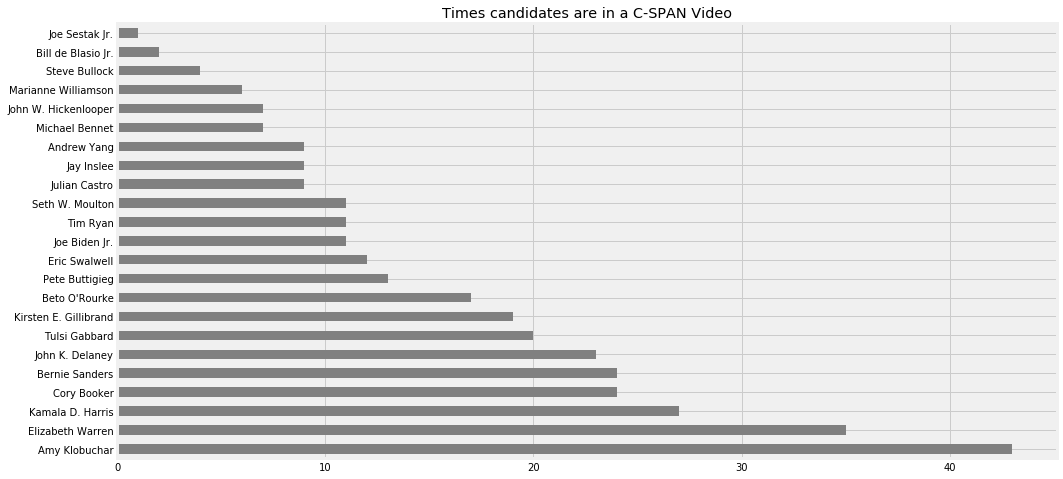

In [45]:
links.Name.value_counts().plot(kind='barh', figsize=(15,8), color="gray", label= "Number of Videos", title="Times candidates are in a C-SPAN Video")

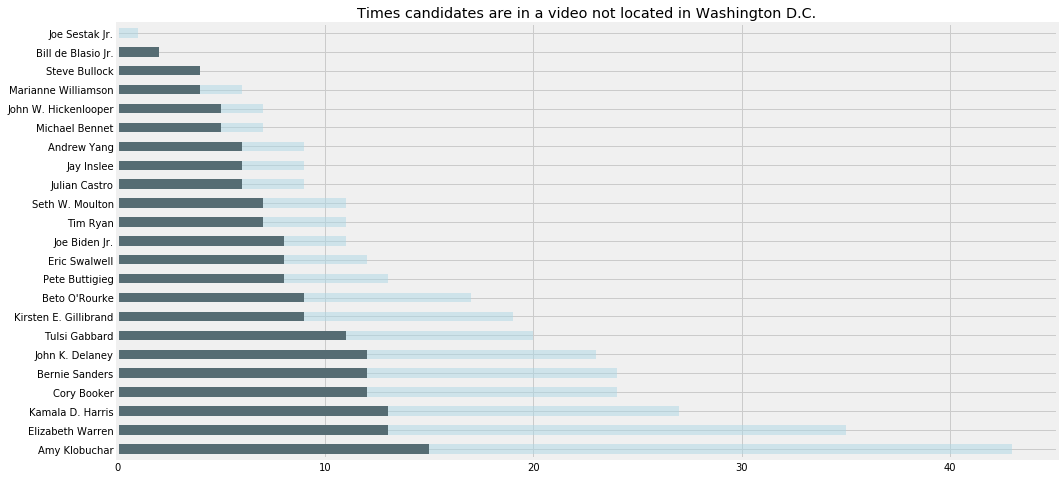

In [46]:
ax = links[links.Location.str.contains(r"Washington, District of Columbia") == False].Name.value_counts().plot(kind='barh', figsize=(15,8), color="black")
links.Name.value_counts().plot(kind='barh', figsize=(15,8), ax=ax, color='lightblue', alpha=.5, title="Times candidates are in a video not located in Washington D.C.")

In [17]:
df = pd.read_csv("candidates-cspan.csv")
df.Slug = df.Slug.astype(str)